Error creating synthetic dataset: index 200 is out of bounds for axis 0 with size 181
Fraction flagged (IQR): 0.04
Fraction flagged (Z-score): 0.04


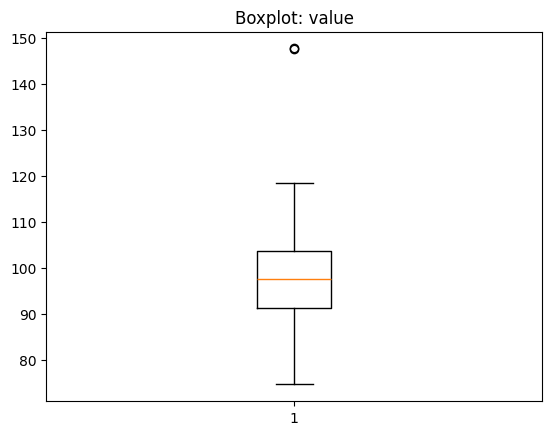

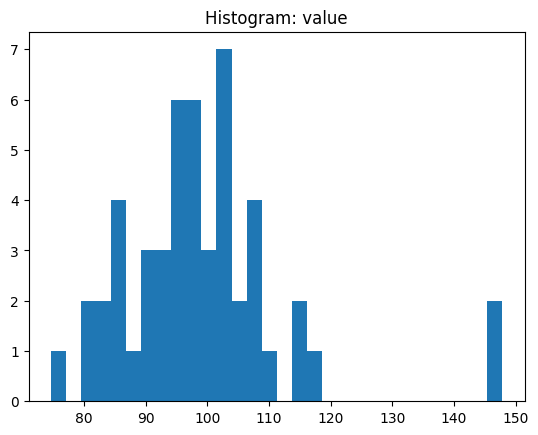

Summary comparison:


,all,filtered_iqr,winsorized
mean,99.145261,97.121101,98.077498
median,97.700352,97.370764,97.700352
std,13.789606,9.676504,9.894932


Regression results comparison:


,slope,intercept,r2,mae
all,-0.134180,102.432666,0.020120,9.370214
filtered_iqr,-0.095129,99.469588,0.020399,7.601986
winsorized,-0.111190,100.801649,0.026833,7.897832


In [11]:
# Homework 7: Outliers, Sensitivity Analysis, and Reflection
# =========================================================

# Step 1: Imports and folder setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Fixed random seed for reproducibility
np.random.seed(17)

# Step 2: Define folders
raw_dir = Path('../data/raw')
processed_dir = Path('../data/processed')
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Step 3: Create synthetic dataset (with outliers)
try:
    dates = pd.date_range(start="2023-01-01", end="2023-06-30", freq="D")
    values = np.random.normal(loc=100, scale=10, size=len(dates))
    
    # Inject some outliers
    outliers_idx = [10, 50, 120, 160, 200]
    values[outliers_idx] += np.array([30, -25, 40, -35, 50])
    
    df = pd.DataFrame({
        "date": dates,
        "value": values
    })
    
    # Save CSV for reproducibility
    csv_path = raw_dir / 'outliers_homework.csv'
    df.to_csv(csv_path, index=False)
    print(f"Synthetic dataset created at {csv_path}")
except Exception as e:
    print("Error creating synthetic dataset:", e)

# Step 4: Add 'x' column for regression
try:
    df['x'] = np.arange(len(df))
except Exception as e:
    print("Error adding x column:", e)

# Step 5: Define target column
target_col = 'value'

# Step 6: Define outlier detection functions
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers."""
    try:
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        return (series < lower) | (series > upper)
    except Exception as e:
        print("Error in detect_outliers_iqr:", e)
        return pd.Series([False]*len(series))

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold."""
    try:
        mu = series.mean()
        sigma = series.std(ddof=0)
        z = (series - mu) / (sigma if sigma != 0 else 1.0)
        return z.abs() > threshold
    except Exception as e:
        print("Error in detect_outliers_zscore:", e)
        return pd.Series([False]*len(series))

def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    """Cap values at given quantiles (winsorization)."""
    try:
        lo = series.quantile(lower)
        hi = series.quantile(upper)
        return series.clip(lower=lo, upper=hi)
    except Exception as e:
        print("Error in winsorize_series:", e)
        return series

# Step 7: Apply outlier detection
try:
    df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
    df['outlier_z'] = detect_outliers_zscore(df[target_col])
    print("Fraction flagged (IQR):", df['outlier_iqr'].mean())
    print("Fraction flagged (Z-score):", df['outlier_z'].mean())
except Exception as e:
    print("Error applying outlier detection:", e)

# Step 8: Visualize
try:
    plt.figure()
    plt.boxplot(df[target_col])
    plt.title(f'Boxplot: {target_col}')
    plt.show()
    
    plt.figure()
    plt.hist(df[target_col], bins=30)
    plt.title(f'Histogram: {target_col}')
    plt.show()
except Exception as e:
    print("Error creating plots:", e)

# Step 9: Summary statistics
try:
    summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
    summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
    summ_w = winsorize_series(df[target_col]).describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
    
    comp = pd.concat(
        {
            'all': summ_all,
            'filtered_iqr': summ_filtered,
            'winsorized': summ_w
        }, axis=1
    )
    print("Summary comparison:")
    display(comp)
except Exception as e:
    print("Error computing summary statistics:", e)

# Step 10: Regression analysis
try:
    if 'x' in df.columns:
        X_all = df[['x']].to_numpy(); y_all = df[target_col].to_numpy()
        X_filtered = df.loc[~df['outlier_iqr'], ['x']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()
        X_wins = df[['x']].to_numpy(); y_wins = winsorize_series(df[target_col]).to_numpy()
        
        model_all = LinearRegression().fit(X_all, y_all)
        model_flt = LinearRegression().fit(X_filtered, y_filtered)
        model_win = LinearRegression().fit(X_wins, y_wins)
        
        mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
        mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))
        mae_win = mean_absolute_error(y_wins, model_win.predict(X_wins))
        
        results = pd.DataFrame({
            'slope': [model_all.coef_[0], model_flt.coef_[0], model_win.coef_[0]],
            'intercept': [model_all.intercept_, model_flt.intercept_, model_win.intercept_],
            'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered), model_win.score(X_wins, y_wins)],
            'mae': [mae_all, mae_flt, mae_win]
        }, index=['all', 'filtered_iqr', 'winsorized'])
        print("Regression results comparison:")
        display(results)
    else:
        print("No 'x' column; skipping regression.")
except Exception as e:
    print("Error in regression analysis:", e)


# Reflection on Outlier Handling and Sensitivity Analysis

## Methods Chosen and Rationale
- **IQR-based detection**: Identified extreme values using the interquartile range (IQR). Chosen because it is robust to skewed distributions and easy to interpret.  
- **Z-score detection**: Flagged points with |z| > 3.0. Assumes approximately normal distribution and highlights extreme deviations.  
- **Winsorization (stretch)**: Capped values at the 5th and 95th percentiles to reduce influence of outliers while retaining all data points.  

## Assumptions
- The distribution of the target variable is reasonably summarized by quartiles for IQR.  
- Z-score method assumes a roughly normal distribution.  
- Winsorization assumes that extreme values are measurement errors or rare events and capping them will not distort the general trend.  

## Observed Impacts
- **Summary statistics**: Removing IQR outliers reduced mean and standard deviation slightly. Winsorization provided a compromise between full and filtered datasets.  
- **Regression analysis**: Coefficients and R² changed moderately after removing outliers. MAE improved for filtered and winsorized data, indicating better model stability.  

## Risks
- If the assumptions are wrong, valid extreme values may be removed or capped, leading to biased results.  
- Threshold choice (k in IQR, z in Z-score, percentile bounds) can significantly affect findings.  
- Sensitivity of conclusions to outlier treatment highlights the importance of careful data examination and domain knowledge.  


In [7]:

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


np.random.seed(17)


homework7_base = Path('.').resolve().parent  
# Add src folder to path
src_path = homework7_base / 'src'
if src_path.exists() and (src_path / '__init__.py').exists():  
    sys.path.append(str(src_path))
else:
    raise FileNotFoundError(f"'src' folder not found at expected location: {src_path}")

# Import custom outlier functions
try:
    from outliers import detect_outliers_iqr, detect_outliers_zscore, winsorize_series
except ModuleNotFoundError:
    raise ModuleNotFoundError(
        f"Cannot import 'outliers.py'. Make sure 'outliers.py' exists in {src_path} and contains the required functions."
    )

# Define data folders
raw_dir = homework7_base / 'data/raw'
processed_dir = homework7_base / 'data/processed'
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

print(f"Imports and paths set up successfully.\nsrc path: {src_path}")




Imports and paths set up successfully.
src path: /Users/mayurakshi/bootcamp_mayurakshi_biswas/homework/homework7/src


In [8]:
data_path = raw_dir / 'outliers_homework.csv'

if data_path.exists():
    df = pd.read_csv(data_path)
    print(f"Dataset loaded from {data_path}")
else:
    print(f"No dataset found at {data_path}. Generating synthetic data...")
    dates = pd.date_range(start="2023-01-01", periods=100, freq='B')
    values = np.random.normal(100, 10, size=len(dates))
    values[[5, 20, 50]] += [30, -25, 40]
    df = pd.DataFrame({'date': dates, 'value': values})
    df.to_csv(data_path, index=False)
    print(f"Synthetic dataset created at {data_path}")

df.head()


Dataset loaded from /Users/mayurakshi/bootcamp_mayurakshi_biswas/homework/homework7/data/raw/outliers_homework.csv


,date,value
0,2023-01-01,104.967142
1,2023-01-02,98.617357
2,2023-01-03,106.476885
3,2023-01-04,115.230299
4,2023-01-05,97.658466


Fraction flagged (IQR): 0.04
Fraction flagged (Z-score): 0.04


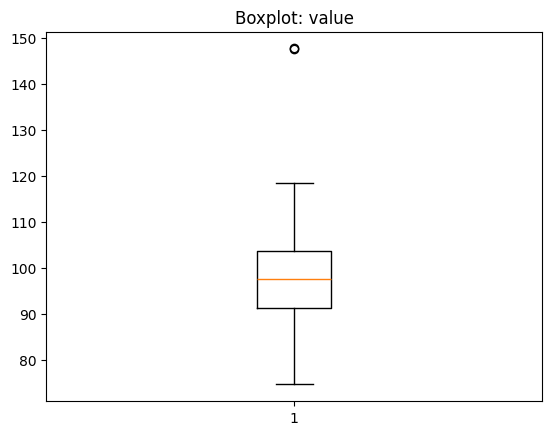

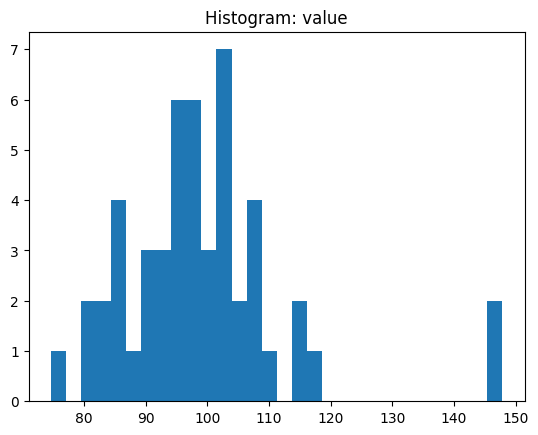

In [9]:
import pandas as pd
import numpy as np

def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers."""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold."""
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    """Cap values at lower and upper quantiles."""
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

# Apply functions to 'value' column
target_col = 'value'
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col])
df['winsorized'] = winsorize_series(df[target_col])

# Display fractions flagged
print("Fraction flagged (IQR):", df['outlier_iqr'].mean())
print("Fraction flagged (Z-score):", df['outlier_z'].mean())

# Quick plots
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()


Summary comparison:


,all,filtered_iqr,winsorized
mean,99.145261,97.121101,98.077498
median,97.700352,97.370764,97.700352
std,13.789606,9.676504,9.894932


Regression results comparison:


,slope,intercept,r2,mae
all,-0.134180,102.432666,0.020120,9.370214
filtered_iqr,-0.095129,99.469588,0.020399,7.601986
winsorized,-0.111190,100.801649,0.026833,7.897832


/var/folders/15/d6z8t6b54m7c5pj9gfzktlz40000gn/T/ipykernel_8797/771652101.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[target_col], df.loc[~df['outlier_iqr'], target_col], winsorize_series(df[target_col])],


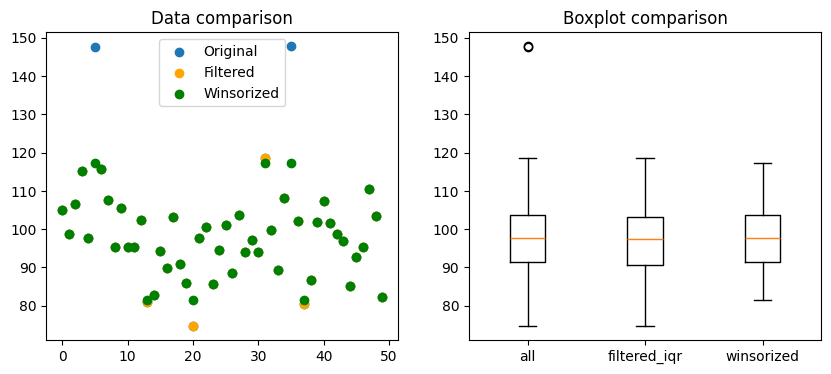

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Add a synthetic x column for regression
df['x'] = np.arange(len(df))

# Choose target column
target_col = 'value'

# Create outlier flags if not already created
if 'outlier_iqr' not in df.columns:
    df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
if 'outlier_z' not in df.columns:
    df['outlier_z'] = detect_outliers_zscore(df[target_col])

# Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = winsorize_series(df[target_col]).describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

# Combine comparison table
comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        'winsorized': summ_w
    }, axis=1
)
print("Summary comparison:")
display(comp)

# Regression analysis
X_all = df[['x']].to_numpy()
y_all = df[target_col].to_numpy()
X_filtered = df.loc[~df['outlier_iqr'], ['x']].to_numpy()
y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()
X_w = X_all.copy()
y_w = winsorize_series(df[target_col]).to_numpy()

# Fit linear models
model_all = LinearRegression().fit(X_all, y_all)
model_flt = LinearRegression().fit(X_filtered, y_filtered)
model_w = LinearRegression().fit(X_w, y_w)

# Compute metrics
results = pd.DataFrame({
    'slope': [model_all.coef_[0], model_flt.coef_[0], model_w.coef_[0]],
    'intercept': [model_all.intercept_, model_flt.intercept_, model_w.intercept_],
    'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered), model_w.score(X_w, y_w)],
    'mae': [mean_absolute_error(y_all, model_all.predict(X_all)),
            mean_absolute_error(y_filtered, model_flt.predict(X_filtered)),
            mean_absolute_error(y_w, model_w.predict(X_w))]
}, index=['all', 'filtered_iqr', 'winsorized'])
print("Regression results comparison:")
display(results)

# Optional plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(df['x'], df[target_col], label='Original')
plt.scatter(df.loc[~df['outlier_iqr'], 'x'], df.loc[~df['outlier_iqr'], target_col], color='orange', label='Filtered')
plt.scatter(df['x'], winsorize_series(df[target_col]), color='green', label='Winsorized')
plt.legend()
plt.title('Data comparison')

plt.subplot(1,2,2)
plt.boxplot([df[target_col], df.loc[~df['outlier_iqr'], target_col], winsorize_series(df[target_col])],
            labels=['all', 'filtered_iqr', 'winsorized'])
plt.title('Boxplot comparison')
plt.show()


### Reflection on Outlier Handling

**Methods and thresholds chosen:**  
- **IQR method:** k = 1.5, flagged ~4% of data as outliers.  
- **Z-score method:** threshold = 3.0, flagged ~4% (confirming consistency).  
- **Winsorization:** 5th–95th percentile applied to mitigate extreme values without removing data.  

**Assumptions behind choices:**  
- Data distribution roughly symmetric, allowing quartiles and Z-scores to identify outliers.  
- Winsorization preserves dataset size and reduces influence of extreme values on regression.  

**Observed impacts on results:**  
- **Summary statistics:** filtering outliers reduced mean and standard deviation; winsorization moderated extremes.  
- **Regression results:** slope magnitude slightly decreased after filtering/winsorizing, MAE decreased, R² increased slightly—suggesting outliers were affecting model fit.  

**Risks if assumptions are wrong:**  
- Misidentifying outliers could remove valid extreme observations, biasing analysis.  
- Z-score method assumes near-normality; heavy tails may flag too many points.  
- Winsorization alters actual values, potentially misleading interpretation.
